# Reading and writing data from AVIRIS-NG in Python

*NOTE: (2018-02-18) Data from 2018 flights will be released early 2019.*

Hyperspectral imagery from the Airborne Visible/InfraRed Imaging Spectrometer-Next Generation (AVIRIS-NG) was collected as part of the Arctic-Boreal Vulnerability Experiment (ABoVE) in 2017 and 2018 and archived at the ORNL DAAC. File sizes can be prohibitively large due to the high spectral resolution of the data. This tutorial aims to show users methods for manipulating hyperspectral imagery efficiently in Python.

## Dataset

### ABoVE: Hyperspectral Imagery from AVIRIS-NG for Alaskan and Canadian Arctic, 2017    
[10.3334/ORNLDAAC/1569](https://doi.org/10.3334/ORNLDAAC/1569)  

**Abstract**     

This dataset provides Level 1 radiance and Level 2 surface reflectance measured by the Airborne Visible/Infrared Imaging Spectrometer-Next Generation (AVIRIS-NG) instrument during flights over the Arctic-Boreal Vulnerability Experiment (ABoVE) domain between June and August 2017. AVIRIS-NG measures reflected radiance at 5-nanometer (nm) intervals in the visible to shortwave infrared spectral range between 380 and 2510 nm. Measurements are radiometrically and geometrically calibrated and provided at approximately 5-meter spatial resolution. The data include 422 flight lines covering areas of interest to the ABoVE campaign over much of Alaska and western Canada. These data will allow researchers to characterize ecosystem structure and function near the height of the growing season. This dataset represents one part of a multisensor airborne sampling campaign conducted by eleven different aircraft teams for ABoVE.


**Citation**     
```
Miller, C.E., R.O. Green, D.R. Thompson, A.K. Thorpe, M. Eastwood, I.B. Mccubbin, W. Olson-duvall, M. Bernas, C.M. Sarture, S. Nolte, L.M. Rios, M.A. Hernandez, B.D. Bue, and S.R. Lundeen. 2018. ABoVE: Hyperspectral Imagery from AVIRIS-NG for Alaskan and Canadian Arctic, 2017. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1569
```

Please see the **User Guide** for a comprehensive description of this dataset:              
https://daac.ornl.gov/ABOVE/guides/ABoVE_Airborne_AVIRIS_NG.html

## Prerequisites           

### Python 3.x
packages: tarfile, gdal, numpy, pandas, matplotlib

### Imagery
Each flight line in the dataset has two corresponding granules, each stored in a zipped tarfile:            
* level 1 radiance, e.g. ang20170624t185017.tar.gz            
* level 2 reflectance, e.g. ang20170624t185017rfl.tar.gz     

This tutorial works with the L2 reflectance image for a flight during late June of the 2017 campaign. **[Click here](https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20170624t185017rfl.tar.gz)** to download the granule. 

Each reflectance tarfile contains two pairs of ENVI binary image files (no extension) and accompanying header files (.hdr):

**Orthocorrected and atmospherically corrected reflectance data**               
*angYYYYMMDDtHHNNSS_corr_VVV_img (& .hdr*)

Atmospherically corrected water-leaving reflectance (Gao et al. 1993; Thompson et al. 2015); 425 bands at 5-nm intervals in the visible to shortwave infrared spectral range from 380 to 2510 nm

**Orthocorrected water absorption data**                  
*angYYYYMMDDtHHNNSS_h2o_VVV_img (& .hdr*)

Retrieved column water vapor and optical absorption paths for liquid H2O and ice; 3 bands: 1. Column water vapor (cm), 2. Total liquid H2O absorption path (cm), 3. Total ice absorption path (cm)

We only use the orthocorrected and atmospherically corrected reflectance data in this tutorial. Section 2 of the User Guide (linked above) gives a detailed description of the rest of the dataset content, including a list of files found in the L1 radiance tarfiles.


## Tutorial

### Clone this repository, download example granule, and start jupyter notebook

NOTE: **[Follow these steps](https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget)** to enable Earthdata authentication for wget or curl.
```
git clone <repolink>
cd <reponame>

curl -b ~/.cookies -c ~/.cookies -n -L -O https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20170624t185017rfl.tar.gz

jupyter notebook
```
Or, **[click here](https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20170624t185017rfl.tar.gz)** to download the example granule.

### Extract the zipped granule

You can either extract the granule using software like 7zip, or use the `tarfile` package to unzip in Python:
```
import tarfile

with tarfile.open("ang20170624t185017rfl.tar.gz", "r:gz") as tar:
    tar.extractall()
```

### Print metadata fields; open reflectance ENVI file

Each ENVI binary image file comes with a header text file (.hdr) of the same name. The header files contains some important metadata about the image. Print a list of metadata elements:

In [1]:
with open("ang20170624t185017_rfl_v2p9/ang20170624t185017_corr_v2p9_img.hdr","r") as f:
    print("Metadata keys:\n"+", ".join([ ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln ]))

Metadata keys:
description, samples, lines, bands, header offset, file type, data type, interleave, byte order, map info, crosstrack scatter file, wavelength units, flat field file, spectral scatter file, wavelength file, wavelength, radiance version, fwhm, rcc file, smoothing factors, data ignore value, bad pixel map, correction factors, bbl


Some of this information is stored by GDAL when the file is opened, xy size and band count, for example. Open the image and print the image dimensions:

In [2]:
from osgeo import gdal,osr

# open the ENVI file
img = gdal.Open("ang20170624t185017_rfl_v2p9/ang20170624t185017_corr_v2p9_img")

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))

Bands:	425
Rows:	2749
Cols:	655


### Get band information

The header file also provides a listed of bands and wavelength. GDAL gives access to a dictionary containing the wavelength of the center of each band using the raster object's `GetMetadata()` method. Make a table describing each of the bands:

In [3]:
import pandas as pd
import numpy as np

# this function classifies bands by wavelength
def classify_bands(b):
    if b < 450: c = "visible-violet"
    elif 450 <= b < 485: c = "visible-blue"
    elif 485 <= b < 500: c = "visible-cyan"
    elif 500 <= b < 565: c = "visible-green"
    elif 565 <= b < 590: c = "visible-yellow"
    elif 590 <= b < 625: c = "visible-orange"
    elif 625 <= b < 740: c = "visible-red"
    elif 740 <= b < 1100: c = "near-infrared"
    elif 1100 <= b < 3000: c = "shortwave-infrared"
    else: c = "welp, something's wrong"
    return(c)

# get lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classify_bands(b) for b in band_centers]

# make data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers ).sort_index()

# print the first five rows
bands.head(5)

Band number  Band center (nm)       EM region
1            1            376.86  visible-violet
2            2            381.87  visible-violet
3            3            386.88  visible-violet
4            4            391.89  visible-violet
5            5            396.89  visible-violet

### Plot the spectra for the center pixel of the image
Data from the raster stack are accessed according to the axes of the underlying numpy array. Extract the value from each band for the center pixel of the image and plot with `matplotlib`: 

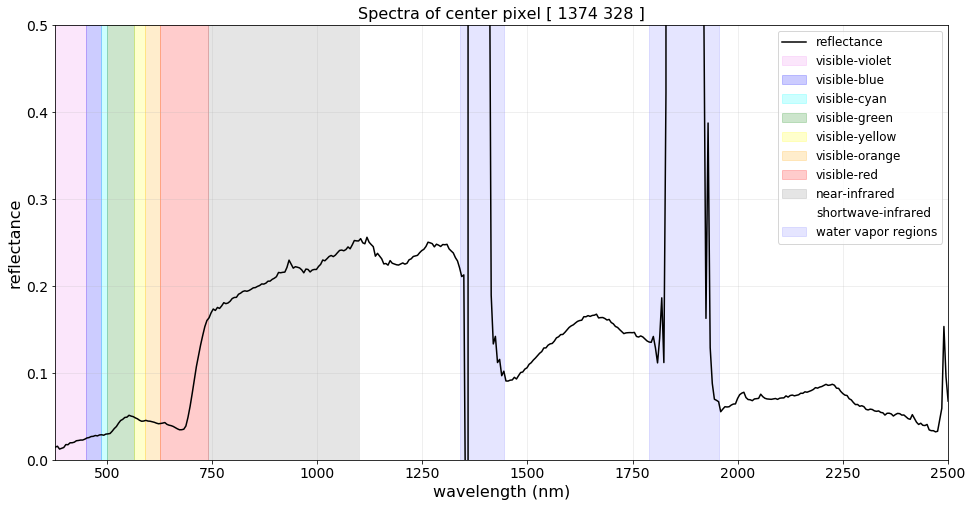

In [4]:
# import matplotlib and settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':1,'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

# function gets value at input xy from input band
get_pixel = lambda img,band,y,x: img.GetRasterBand(band).ReadAsArray()[y,x]

# get value of center pixel for all bands and add to new data frame
ycenter, xcenter = int(round(nrows/2)), int(round(ncols/2))
_bands = bands
_bands['reflectance'] = [get_pixel(img,b,ycenter,xcenter) for b in range(1,nbands+1)]

# plot. all of this is matplotlib ---------->
_bands.plot(x='Band center (nm)', y='reflectance', c='black')

ax = plt.gca() 
ax.axvspan(375, 450, alpha=0.2, color='violet', label='visible-violet')
ax.axvspan(450, 485, alpha=0.2, color='blue', label='visible-blue')
ax.axvspan(485, 500, alpha=0.2, color='cyan', label='visible-cyan')
ax.axvspan(500, 565, alpha=0.2, color='green', label='visible-green')
ax.axvspan(565, 590, alpha=0.2, color='yellow', label='visible-yellow')
ax.axvspan(590, 625, alpha=0.2, color='orange', label='visible-orange')
ax.axvspan(625, 740, alpha=0.2, color='red', label='visible-red')
ax.axvspan(740, 1100, alpha=0.2, color='gray', label='near-infrared')
ax.axvspan(1100, 2500, alpha=0.2, color='white', label='shortwave-infrared')
ax.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
ax.axvspan(1790, 1955, alpha=0.1, color='blue')

plt.title(" ".join(["Spectra of center pixel [",str(ycenter),str(xcenter),"]"]), fontdict = titlefont)
ax.set_ylim(0,0.5)
ax.set_xlim(min(band_centers),max(band_centers))
ax.set_ylabel("reflectance", fontsize=16)
ax.set_xlabel("wavelength (nm)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid('on', alpha=0.25)
plt.legend(prop={'size': 12})

### Plot RGB bands
We also access individual or groups of bands by indexing the numpy array. Extract the R, G, and B bands from the image and prep to plot in three steps:            
    
    a. determine bands nearest the center of red, green, blue regions of EM spectrum      
    b. extract the bands and scale reflectance values to 8-bits       
    c. stack the bands   

In [5]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                  59
Band center (nm)         667.36
EM region           visible-red
reflectance           0.0355713
Name: 59, dtype: object
------------------------------------------------------------
Band number                    34
Band center (nm)           542.15
EM region           visible-green
reflectance             0.0486855
Name: 34, dtype: object
------------------------------------------------------------
Band number                   20
Band center (nm)          472.02
EM region           visible-blue
reflectance             0.027933
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (2749, 655, 3)


**Now plot with `matplotlib`:**

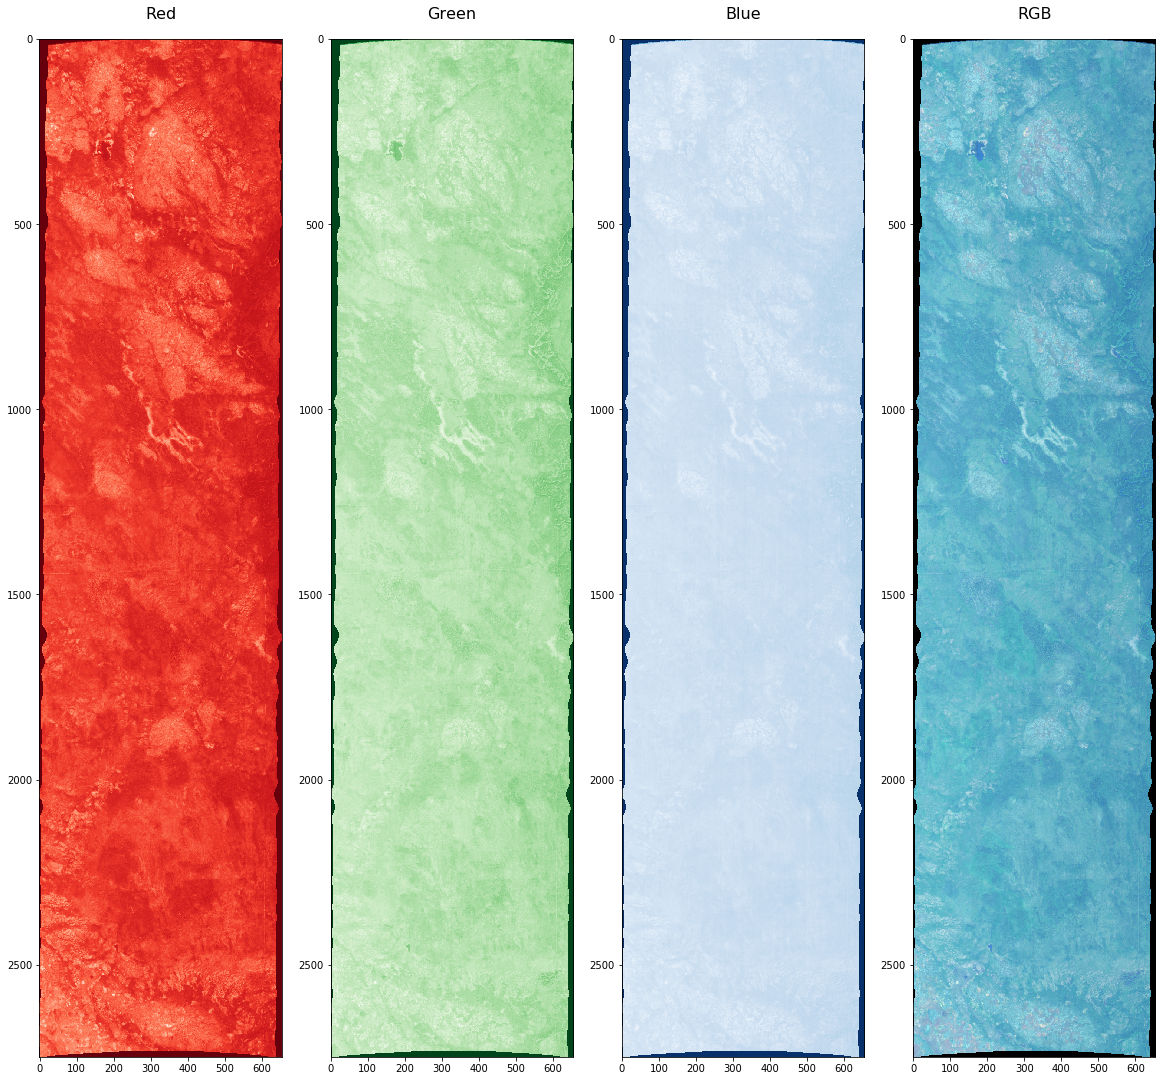

In [6]:
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim)
    ax.set_title(band, pad = 20, fontdict = titlefont)
plt.imshow(rgb_stack)

### Calculate vegetation indices

Reflectance measurements represent the ratio of reflected over incoming radiation, so values are between zero and one.

**Normalized Difference Vegetation Index (NDVI)** is a simple metric used to get a general sense of the quantity and condition of the vegetation on the earth's surface. NDVI takes advantage of the strong difference in reflectivity of vegetation in the red and near-infrared ranges.      

The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 nm to 1100 nm). The more leaves a plant has, the more these wavelengths of light are affected, respectively.       

NDVI is traditionally calculated as follows:
```
NDVI = (R900-R685)/(R900+R685)
```
**Select the bands nearest to recommended NDVI bands 685 nm (red) and 900 nm (near-infrared):**

In [7]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("\n"+"---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))

Band number                  63
Band center (nm)          687.4
EM region           visible-red
reflectance            0.038841
Name: 63, dtype: object
------------------------------------------------------------
Band number                   105
Band center (nm)           897.76
EM region           near-infrared
reflectance              0.208738
Name: 105, dtype: object

------------------------------------------------------------
NDVI stats --- mean: 0.66639537, std: 0.080925114, min: -1.1523409, max: 1.0565037


### More broadband indices

**Simple Ratio (SR; Birth and McVey 1968)**       
* the ratio of (1) the wavelength with highest reflectance for vegetation and (2) the wavelength of the deepest chlorophyll absorption. The simple equation is easy to understand and is effective over a wide range of conditions. As with the NDVI, it can saturate in dense vegetation when LAI becomes very high.   
* values range ~1-30
* Birth, G., and G. McVey. "Measuring the Color of Growing Turf with a Reflectance Spectrophotometer." Agronomy Journal 60 (1968): 640-643. https://doi.org/10.2134/agronj1968.00021962006000060016x       
```
SR = R750/R705
```

**Soil Adjusted Vegetation Index (SAVI; Huete 1988)**       
* similar to NDVI, but it suppresses the effects of soil pixels. It uses a canopy background adjustment factor, L, which is a function of vegetation density and often requires prior knowledge of vegetation amounts      
* Huete, A. "A Soil-Adjusted Vegetation Index (SAVI)." Remote Sensing of Environment 25 (1988): 295-309. https://doi.org/10.1016/0034-4257(88)90106-X     

```
SAVI = L*(R900-R685)/(R900+R685+L); where L is a canopy background adjustment factor   
```
L value of 0.5 in reflectance space was found to minimize soil brightness variations and eliminate the need for additional calibration for different soils. The transformation was found to nearly eliminate soil-induced variations in vegetation indices (Huete et al. 1988)

In [8]:
# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

**Plot NDVI, SR, and SAVI:**

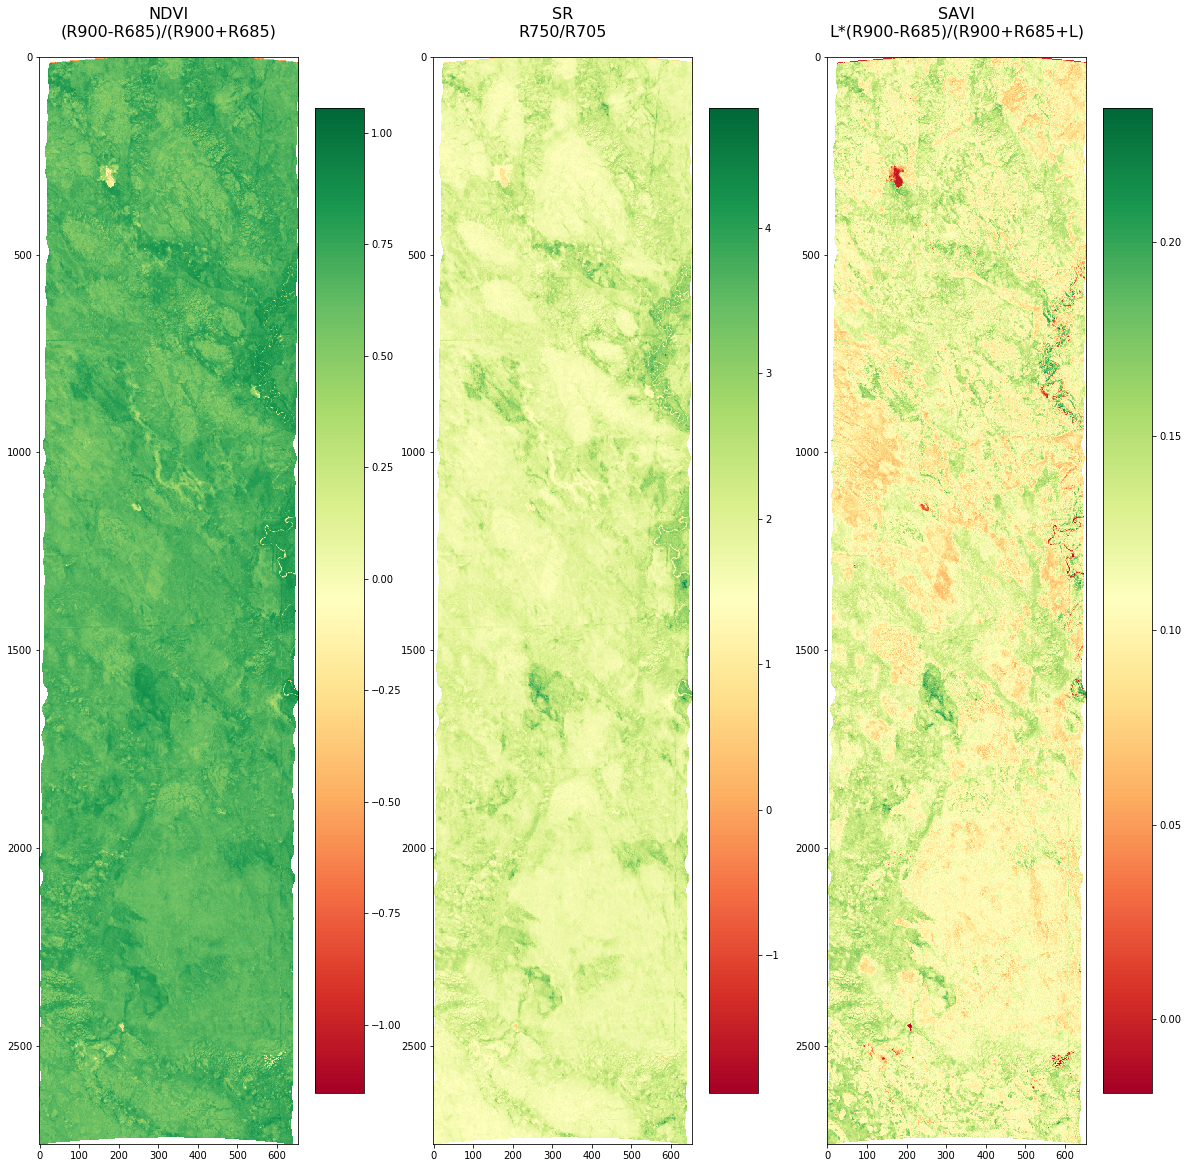

In [9]:
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow( data['array'], cmap=plt.get_cmap("RdYlGn") )
    ax.set_title(band, pad = 20, fontdict = titlefont)
    plt.colorbar(p)

### Saving to GeoTIFF

Use GDAL to write a subset of bands or derived metrics to GeoTIFF:

In [10]:
# get spatial metadata
ncols = img.RasterXSize
nrows = img.RasterYSize
bands = img.RasterCount
geotransform = img.GetGeoTransform()
xorigin = geotransform[0]
yorigin = geotransform[3]
cellwidth = geotransform[1]
cellheight = geotransform[5]

# create a new GeoTIFF for writing
out1 = gdal.GetDriverByName( 'GTiff' ).Create( 
    'output-band1.tif',             # output filename
    ncols,                          # number of columns
    nrows,                          # number of rows
    1,                              # number of bands
    1                               # data type (float32)
)

# set GDAL-style output geotransform (6-tuple)
out1.SetGeoTransform(( 
    geotransform[0],                # x minimum
    geotransform[1],                # x resolution
    0,                              # x offset
    geotransform[3],                # y maximum
    0,                              # y offset
    -geotransform[5]                # -y resolution
))

# assign wkt to output
out1.SetProjection( img.GetProjection() )

# write band 1 to output
b = out1.GetRasterBand(1) 
b.WriteArray( img.GetRasterBand(1).ReadAsArray() )  
b.SetNoDataValue( -9999. )

out1.FlushCache()
img, out1 = None, None